# Inspect Data

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib.colors import rgb2hex

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from keras.layers import Input, Dense
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.manifold import TSNE


## Loading dataset and creating dfs

In [2]:
# Load the feature names
features = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/features.txt', sep='\s+', header=None)

# Create unique feature names by combining the index and the feature name. This avoids an issue with duplicate entries
unique_column_names = [f"{row[0]}_{row[1]}" for index, row in features.iterrows()]

# Load X_train and X_test
X_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None, names=unique_column_names)
X_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None, names=unique_column_names)

# Load y_train and y_test
y_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None)
y_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None)

# From the test dataset, create a validation dataset
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Load the different subjects
subject_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt', sep='\s+', header=None)
subject_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt', sep='\s+', header=None)

# Concatenate subject_train and X_train along the columns
X_train_with_subject = pd.concat([subject_train, X_train], axis=1)

# Optionally, name the columns for clarity (e.g., "Subject" for the subject column)
X_train_with_subject.columns = ['subject'] + unique_column_names
X_train_with_subject

,subject,1_tBodyAcc-mean()-X,2_tBodyAcc-mean()-Y,3_tBodyAcc-mean()-Z,4_tBodyAcc-std()-X,5_tBodyAcc-std()-Y,6_tBodyAcc-std()-Z,7_tBodyAcc-mad()-X,8_tBodyAcc-mad()-Y,9_tBodyAcc-mad()-Z,...,552_fBodyBodyGyroJerkMag-meanFreq(),553_fBodyBodyGyroJerkMag-skewness(),554_fBodyBodyGyroJerkMag-kurtosis(),"555_angle(tBodyAccMean,gravity)","556_angle(tBodyAccJerkMean,gravityMean)","557_angle(tBodyGyroMean,gravityMean)","558_angle(tBodyGyroJerkMean,gravityMean)","559_angle(X,gravityMean)","560_angle(Y,gravityMean)","561_angle(Z,gravityMean)"
0,1,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,-0.074323,-0.298676,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627
1,1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,0.158075,-0.595051,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317
2,1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,0.414503,-0.390748,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118
3,1,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,0.404573,-0.117290,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663
4,1,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,0.087753,-0.351471,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7347,30,0.299665,-0.057193,-0.181233,-0.195387,0.039905,0.077078,-0.282301,0.043616,0.060410,...,-0.070157,-0.588433,-0.880324,-0.190437,0.829718,0.206972,-0.425619,-0.791883,0.238604,0.049819
7348,30,0.273853,-0.007749,-0.147468,-0.235309,0.004816,0.059280,-0.322552,-0.029456,0.080585,...,0.165259,-0.390738,-0.680744,0.064907,0.875679,-0.879033,0.400219,-0.771840,0.252676,0.050053
7349,30,0.273387,-0.017011,-0.045022,-0.218218,-0.103822,0.274533,-0.304515,-0.098913,0.332584,...,0.195034,0.025145,-0.304029,0.052806,-0.266724,0.864404,0.701169,-0.779133,0.249145,0.040811
7350,30,0.289654,-0.018843,-0.158281,-0.219139,-0.111412,0.268893,-0.310487,-0.068200,0.319473,...,0.013865,0.063907,-0.344314,-0.101360,0.700740,0.936674,-0.589479,-0.785181,0.246432,0.025339


## Checking Class distributions

In [3]:
# Create a mapping for numerical labels
label_mapping = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}

# Create a df that contains both numerical and catagorical labels. Useful for plotting graphs
y_train_labels = y_train.copy()
y_train_labels['Descriptive Label'] = y_train_labels[0].replace(label_mapping)

y_test_labels = y_test.copy()
y_test_labels['Descriptive Label'] = y_test_labels[0].replace(label_mapping)

y_val_labels = y_val.copy()
y_val_labels['Descriptive Label'] = y_val_labels[0].replace(label_mapping)

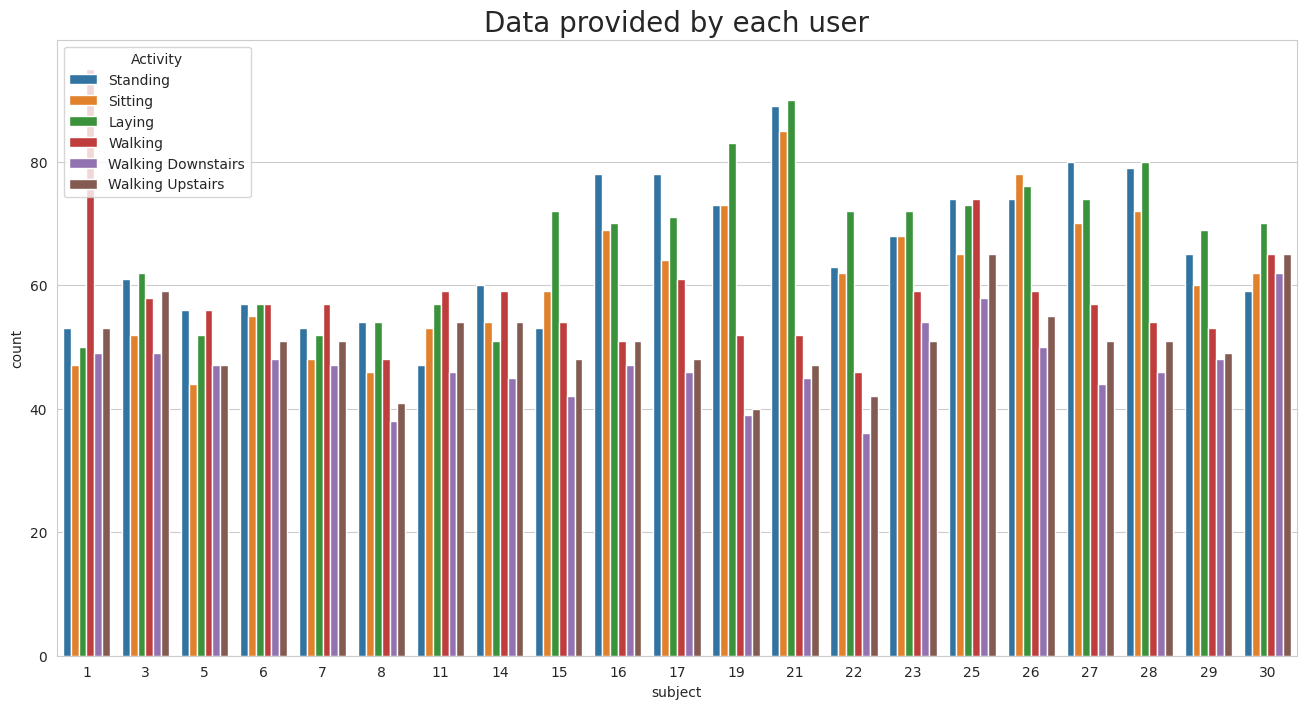

In [4]:
train = pd.concat([X_train_with_subject, y_train_labels], axis=1)

# Optionally, name the label columns for clarity
train.columns = list(X_train_with_subject.columns) + ['Numerical Label', 'Activity']

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='Activity', data = train)
plt.show()

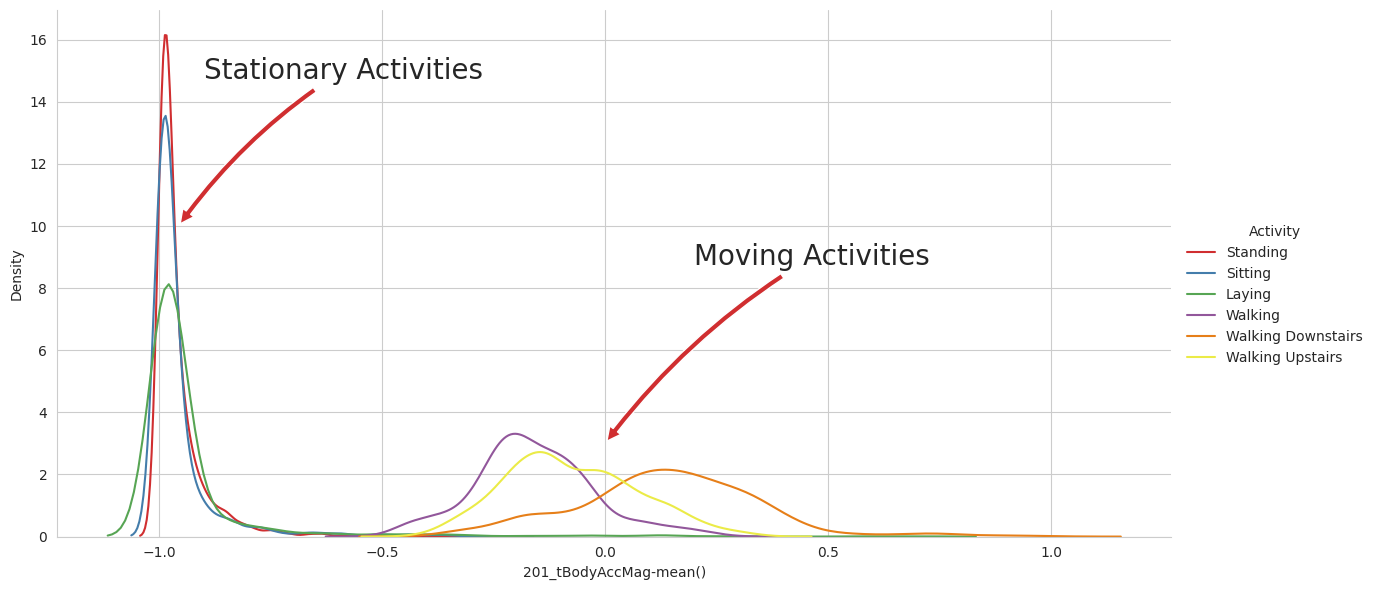

In [5]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train, hue='Activity', height=6, aspect=2)
facetgrid.map(sns.kdeplot,'201_tBodyAccMag-mean()',).add_legend()
plt.annotate("Stationary Activities", xy=(-0.956,10), xytext=(-0.9, 15), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show()

In [6]:
train.head()

,subject,1_tBodyAcc-mean()-X,2_tBodyAcc-mean()-Y,3_tBodyAcc-mean()-Z,4_tBodyAcc-std()-X,5_tBodyAcc-std()-Y,6_tBodyAcc-std()-Z,7_tBodyAcc-mad()-X,8_tBodyAcc-mad()-Y,9_tBodyAcc-mad()-Z,...,554_fBodyBodyGyroJerkMag-kurtosis(),"555_angle(tBodyAccMean,gravity)","556_angle(tBodyAccJerkMean,gravityMean)","557_angle(tBodyGyroMean,gravityMean)","558_angle(tBodyGyroJerkMean,gravityMean)","559_angle(X,gravityMean)","560_angle(Y,gravityMean)","561_angle(Z,gravityMean)",Numerical Label,Activity
0,1,0.288585,-0.020294,-0.132905,-0.995279,-0.983111,-0.913526,-0.995112,-0.983185,-0.923527,...,-0.710304,-0.112754,0.030400,-0.464761,-0.018446,-0.841247,0.179941,-0.058627,5,Standing
1,1,0.278419,-0.016411,-0.123520,-0.998245,-0.975300,-0.960322,-0.998807,-0.974914,-0.957686,...,-0.861499,0.053477,-0.007435,-0.732626,0.703511,-0.844788,0.180289,-0.054317,5,Standing
2,1,0.279653,-0.019467,-0.113462,-0.995380,-0.967187,-0.978944,-0.996520,-0.963668,-0.977469,...,-0.760104,-0.118559,0.177899,0.100699,0.808529,-0.848933,0.180637,-0.049118,5,Standing
3,1,0.279174,-0.026201,-0.123283,-0.996091,-0.983403,-0.990675,-0.997099,-0.982750,-0.989302,...,-0.482845,-0.036788,-0.012892,0.640011,-0.485366,-0.848649,0.181935,-0.047663,5,Standing
4,1,0.276629,-0.016570,-0.115362,-0.998139,-0.980817,-0.990482,-0.998321,-0.979672,-0.990441,...,-0.699205,0.123320,0.122542,0.693578,-0.615971,-0.847865,0.185151,-0.043892,5,Standing


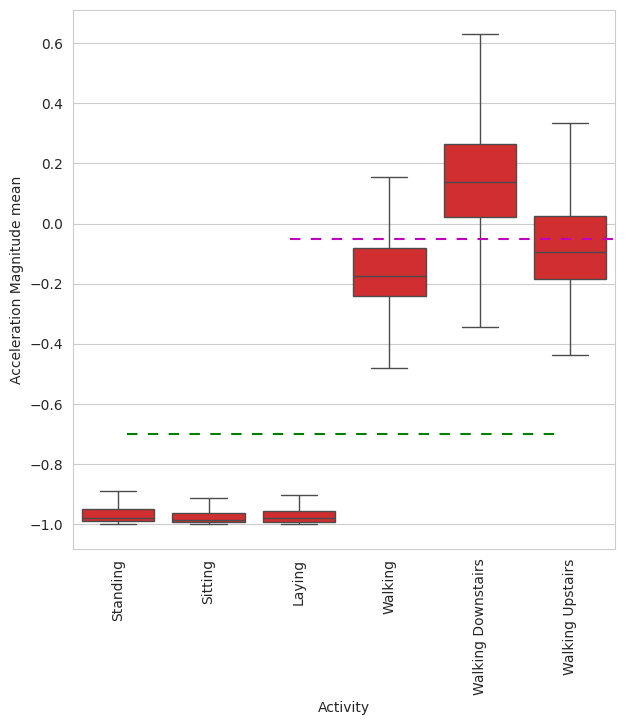

In [7]:
plt.figure(figsize=(7,7))
sns.boxplot(x='Activity', y='201_tBodyAccMag-mean()',data=train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

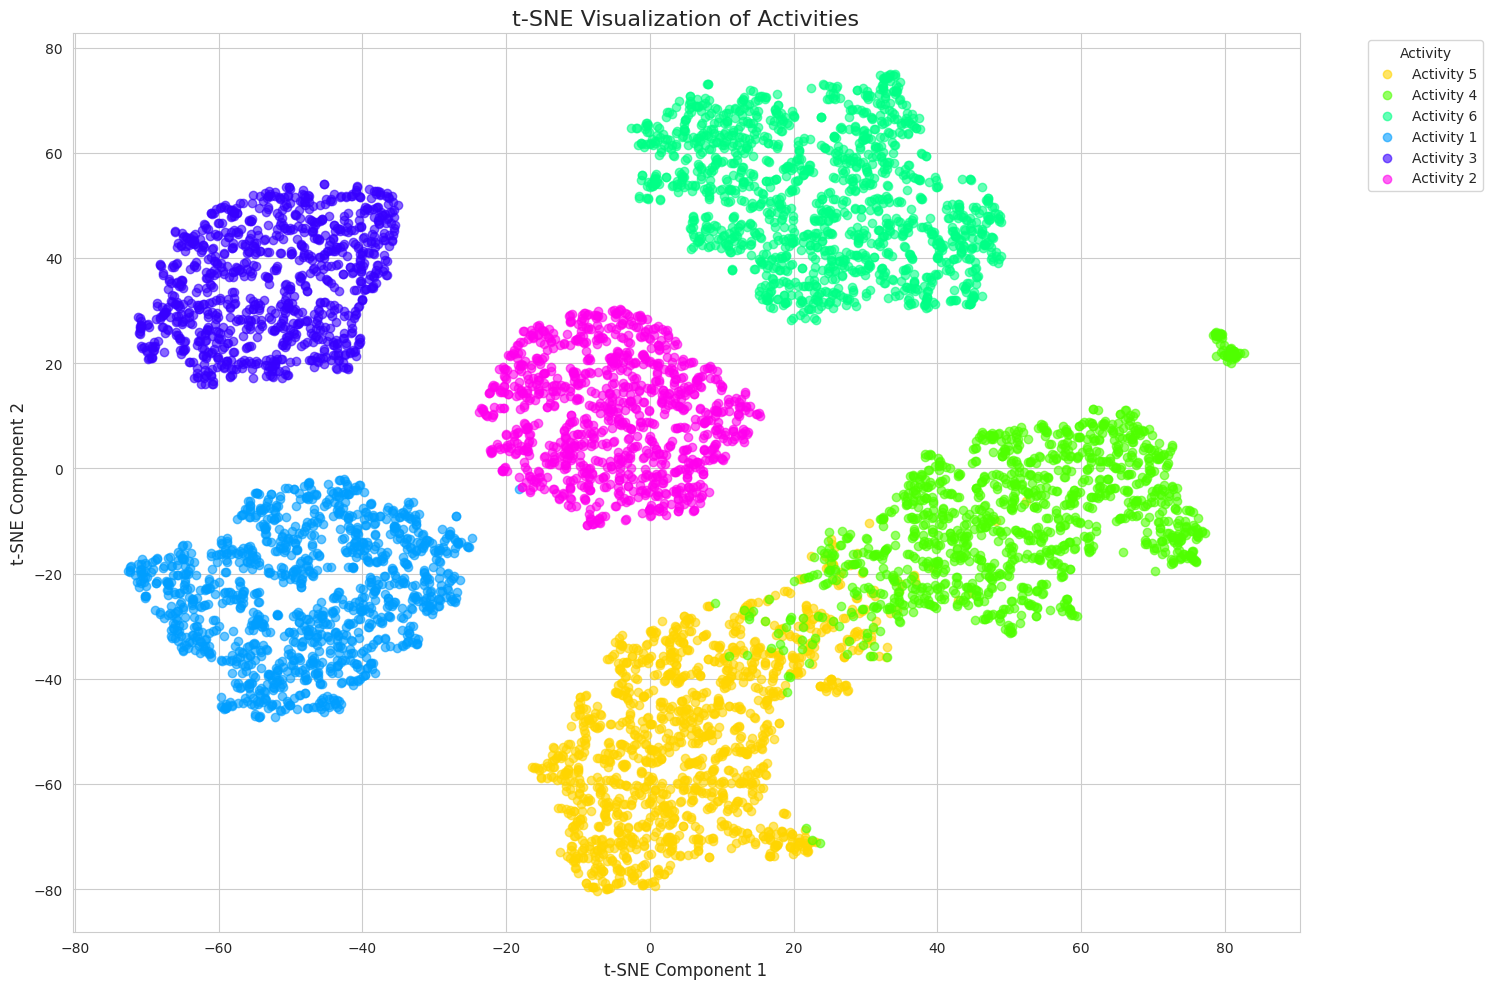

In [8]:
# Prepare data
features = train.drop(['Activity', 'Numerical Label', 'subject'], axis=1)
labels = train['Numerical Label']

# Standardize features
scl = StandardScaler()
features_scaled = scl.fit_transform(features)

# Apply PCA
lda = LDA()
lda_transformed = lda.fit_transform(features_scaled, labels)

# Apply t-SNE
tsne = TSNE(random_state=42)
tsne_transformed = tsne.fit_transform(lda_transformed)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Generate colors
n = len(labels.unique())
colors = sns.color_palette('hsv', n)

# Plot each activity
for i, group in enumerate(labels.unique()):
    mask = labels == group
    ax.scatter(
        tsne_transformed[mask][:, 0],
        tsne_transformed[mask][:, 1],
        color=colors[i],
        alpha=0.6,
        label=f"Activity {group}"
    )

# Add labels, legend, and title
ax.set_title("t-SNE Visualization of Activities", fontsize=16)
ax.set_xlabel("t-SNE Component 1", fontsize=12)
ax.set_ylabel("t-SNE Component 2", fontsize=12)
ax.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [9]:
# Check for class distribution in y_train
class_distribution_train = y_train[0].value_counts()
print("Class distribution in y_train:")
print(class_distribution_train)

# Check for class distribution in y_val
class_distribution_val = y_val[0].value_counts()
print("\nClass distribution in y_test:")
print(class_distribution_val)

# Check for class distribution in y_test
class_distribution_test = y_test[0].value_counts()
print("\nClass distribution in y_test:")
print(class_distribution_test)

Class distribution in y_train:
0
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64

Class distribution in y_test:
0
5    278
6    258
1    254
4    235
2    225
3    223
Name: count, dtype: int64

Class distribution in y_test:
0
6    279
4    256
5    254
2    246
1    242
3    197
Name: count, dtype: int64


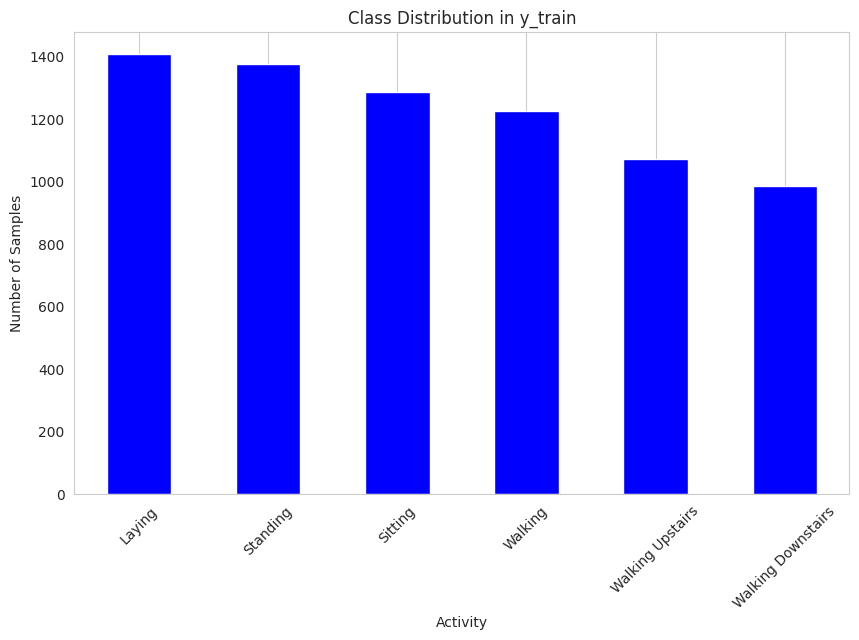

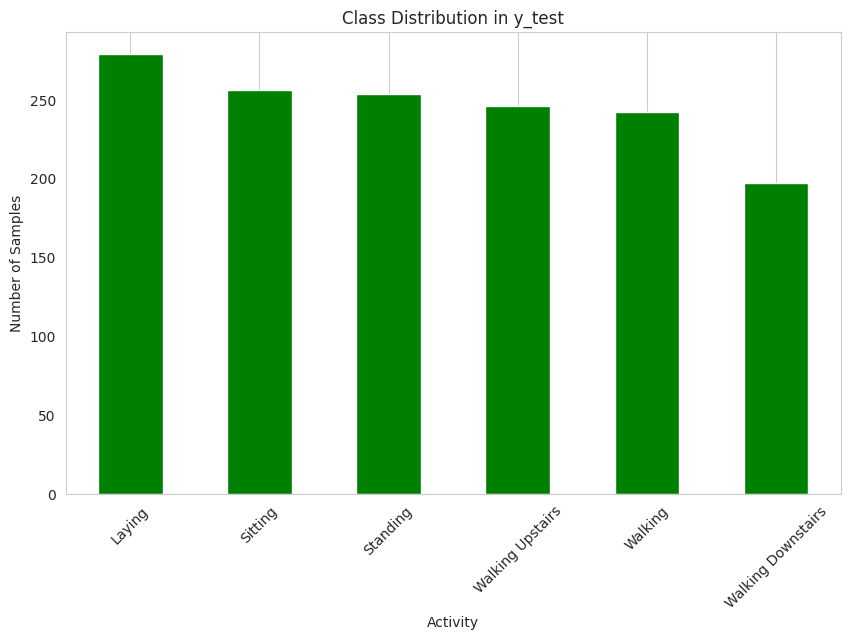

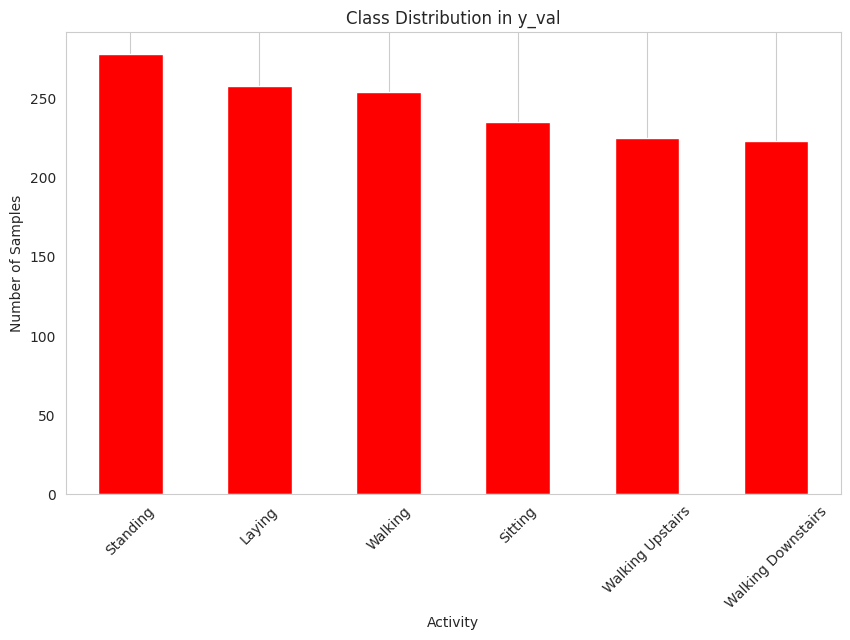

In [10]:
# Bar chart for y_train class distribution
class_distribution_train = y_train_labels['Descriptive Label'].value_counts()
plt.figure(figsize=(10, 6))
class_distribution_train.plot(kind='bar', color='blue')
plt.title('Class Distribution in y_train')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Bar chart for y_train class distribution
class_distribution_test = y_test_labels['Descriptive Label'].value_counts()
plt.figure(figsize=(10, 6))
class_distribution_test.plot(kind='bar', color='green')
plt.title('Class Distribution in y_test')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Bar chart for y_val class distribution
class_distribution_val = y_val_labels['Descriptive Label'].value_counts()
plt.figure(figsize=(10, 6))
class_distribution_val.plot(kind='bar', color='red')
plt.title('Class Distribution in y_val')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Check and deal with missing values and duplicates

In [11]:
# Check for missing values in X_train
missing_values_X_train = X_train.isnull().sum()
print("Missing values in X_train:\n", missing_values_X_train[missing_values_X_train > 0])

# Check for missing values in X_test
missing_values_X_test = X_test.isnull().sum()
print("\nMissing values in X_test:\n", missing_values_X_test[missing_values_X_test > 0])

# Check for missing values in y_train
missing_values_y_train = y_train.isnull().sum()
print("\nMissing values in y_train:\n", missing_values_y_train[missing_values_y_train > 0])

# Check for missing values in y_test
missing_values_y_test = y_test.isnull().sum()
print("\nMissing values in y_test:\n", missing_values_y_test[missing_values_y_test > 0])

Missing values in X_train:
 Series([], dtype: int64)

Missing values in X_test:
 Series([], dtype: int64)

Missing values in y_train:
 Series([], dtype: int64)

Missing values in y_test:
 Series([], dtype: int64)


In [12]:
print('No of duplicates in X_train: {}'.format(sum(X_train.duplicated())))
print('No of duplicates in X_test : {}'.format(sum(X_test.duplicated())))

No of duplicates in X_train: 0
No of duplicates in X_test : 0


## Identify Correlations Between Features. May not be useful yet.

In [13]:
# Assuming X_train is your training dataset as a DataFrame
correlation_matrix = X_train.corr()

# Set a threshold for correlation
threshold = 0.75

# Get the absolute correlation matrix
abs_correlation = correlation_matrix.abs()

# Create a DataFrame to hold the pairs of correlated features
highly_correlated_pairs = []

# Iterate through the correlation matrix
for i in range(len(abs_correlation.columns)):
    for j in range(i):
        # Check if the correlation is above the threshold and features are different
        if abs_correlation.iloc[i, j] > threshold and abs_correlation.columns[i] != abs_correlation.columns[j]:
            highly_correlated_pairs.append((abs_correlation.columns[i], abs_correlation.columns[j], abs_correlation.iloc[i, j]))

# Create a DataFrame for better visualization
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Print only the pairs of highly correlated features where Feature 1 is different from Feature 2
print("Highly correlated features:")
print(highly_correlated_df)

Highly correlated features:
                      Feature 1                  Feature 2  Correlation
0            5_tBodyAcc-std()-Y         4_tBodyAcc-std()-X     0.927461
1            6_tBodyAcc-std()-Z         4_tBodyAcc-std()-X     0.851668
2            6_tBodyAcc-std()-Z         5_tBodyAcc-std()-Y     0.895510
3            7_tBodyAcc-mad()-X         4_tBodyAcc-std()-X     0.998632
4            7_tBodyAcc-mad()-X         5_tBodyAcc-std()-Y     0.922803
...                         ...                        ...          ...
29480  560_angle(Y,gravityMean)  58_tGravityAcc-energy()-Y     0.880564
29481  560_angle(Y,gravityMean)   559_angle(X,gravityMean)     0.783848
29482  561_angle(Z,gravityMean)    43_tGravityAcc-mean()-Z     0.995070
29483  561_angle(Z,gravityMean)     52_tGravityAcc-max()-Z     0.992869
29484  561_angle(Z,gravityMean)     55_tGravityAcc-min()-Z     0.990991

[29485 rows x 3 columns]


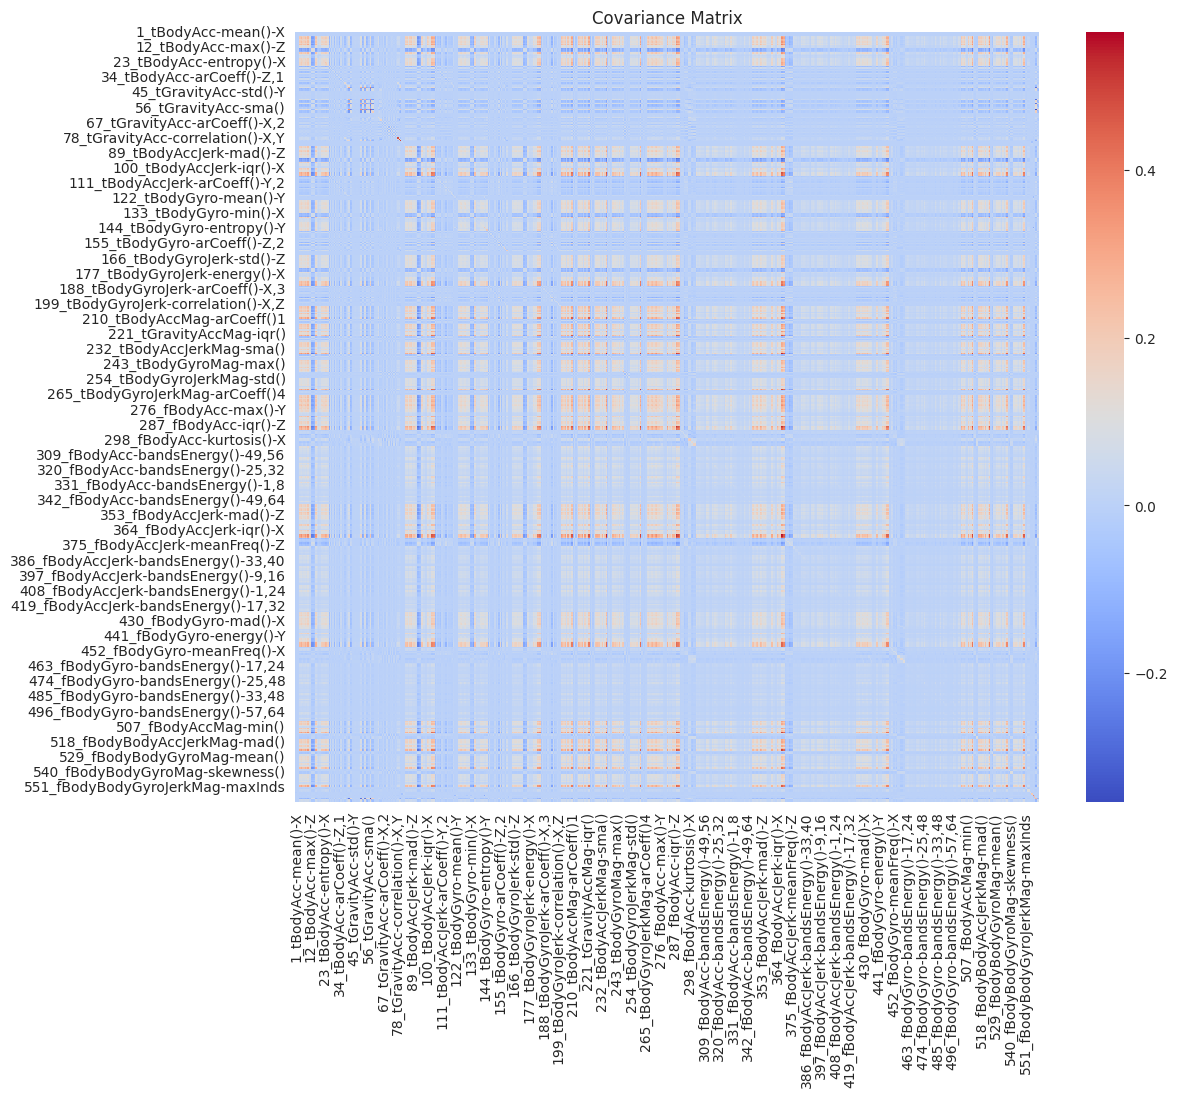

In [14]:
# Step 1: Compute the covariance matrix
cov_matrix = np.cov(features.T)  # Transpose ensures features are treated as variables

# Step 2: Create a DataFrame for better readability
cov_df = pd.DataFrame(cov_matrix, index=features.columns, columns=features.columns)

# Step 3: Plot the covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cov_df, annot=False, cmap='coolwarm', cbar=True)
plt.title("Covariance Matrix")
plt.show()

## Identify number of components needed for PCA to maintain 95% of Variance

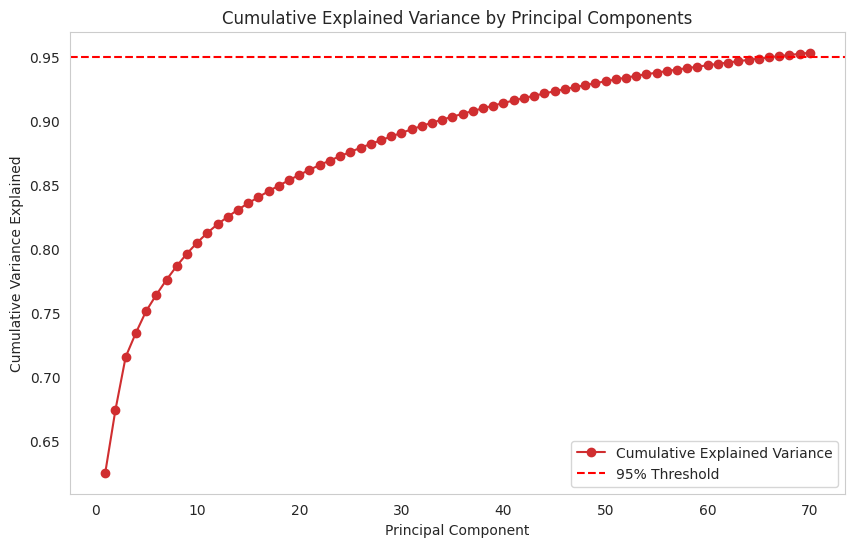

Total variance explained by the first 1 components: 0.6255
Total variance explained by the first 2 components: 0.6747
Total variance explained by the first 3 components: 0.7159
Total variance explained by the first 4 components: 0.7346
Total variance explained by the first 5 components: 0.7516
Total variance explained by the first 6 components: 0.7643
Total variance explained by the first 7 components: 0.7761
Total variance explained by the first 8 components: 0.7868
Total variance explained by the first 9 components: 0.7965
Total variance explained by the first 10 components: 0.8050
Total variance explained by the first 11 components: 0.8127
Total variance explained by the first 12 components: 0.8194
Total variance explained by the first 13 components: 0.8252
Total variance explained by the first 14 components: 0.8308
Total variance explained by the first 15 components: 0.8357
Total variance explained by the first 16 components: 0.8405
Total variance explained by the first 17 componen

In [162]:
# Fit PCA on your dataset
pca = PCA(n_components=70)
X_train_pca = pca.fit_transform(X_train)  # Use fit_transform to get the transformed data
explained_variance = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = explained_variance.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, marker='o', label='Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Cumulative Variance Explained')
plt.grid()
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Threshold')  # Optional: add a line for the 90% threshold
plt.legend()
plt.show()

# Print total variance explained by each principal component
for i, var in enumerate(cumulative_variance):
    print(f'Total variance explained by the first {i + 1} components: {var:.4f}')

## Transform X_train and X_test using PCA

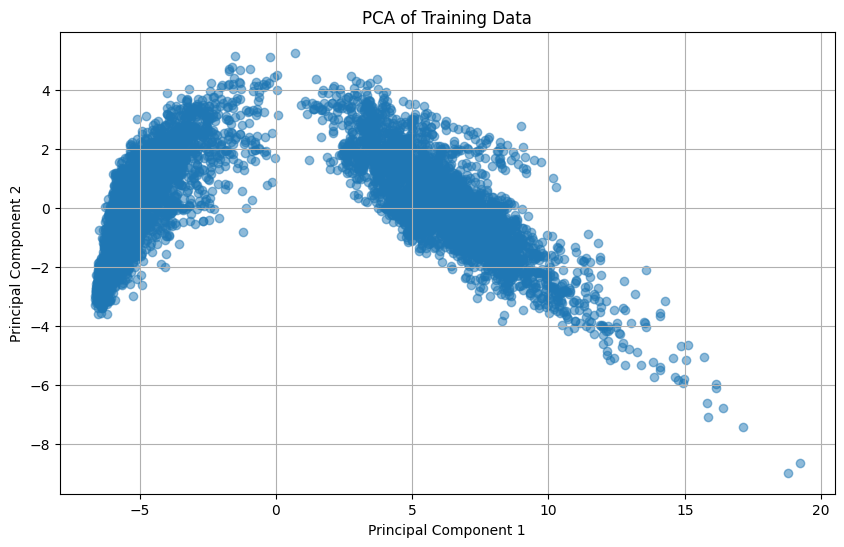

In [9]:
# Apply dimensionality reduction using PCA with optimnal n_components
pca = PCA(n_components=67)
X_train_pca = pca.fit_transform(X_train) # Fit to train data to prevent leakage and then transform
X_test_pca = pca.transform(X_test) # transform test and val data
X_val_pca = pca.transform(X_val)


# Scatter Plot of the First Two Principal Components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


## Detect and Deal with Anomolies. Should do this before PCA if we are goint to do it.

In [10]:
'''# Define the threshold for anomaly detection
threshold = 3

# Initialize a variable to keep track of the maximum number of anomalies
max_anomalies = 0
max_anomalies_column = None

# Iterate through each column in the training dataset
for col in X_train.columns:
    # Calculate Z-scores for the column
    z_scores_train = (X_train[col] - X_train[col].mean()) / X_train[col].std()

    # Identify anomalies in the column
    anomalies_train = (z_scores_train > threshold) | (z_scores_train < -threshold)

    # Get indices of anomalies for the current column
    anomaly_indices_train = np.where(anomalies_train)[0]

    # Count the number of anomalies detected for the current column
    num_anomalies = len(anomaly_indices_train)
    
    # Print number of anomalies detected for the current column
    print(f'Column {col}: Number of anomalies in training set: {num_anomalies}')

    # Check if the current number of anomalies is greater than the max found so far
    if num_anomalies > max_anomalies:
        max_anomalies = num_anomalies
        max_anomalies_column = col

# After iterating through all columns, print the maximum number of anomalies found
print(f'Maximum number of anomalies detected in a single column: {max_anomalies} (Column {max_anomalies_column})')'''

"# Define the threshold for anomaly detection\nthreshold = 3\n\n# Initialize a variable to keep track of the maximum number of anomalies\nmax_anomalies = 0\nmax_anomalies_column = None\n\n# Iterate through each column in the training dataset\nfor col in X_train.columns:\n    # Calculate Z-scores for the column\n    z_scores_train = (X_train[col] - X_train[col].mean()) / X_train[col].std()\n\n    # Identify anomalies in the column\n    anomalies_train = (z_scores_train > threshold) | (z_scores_train < -threshold)\n\n    # Get indices of anomalies for the current column\n    anomaly_indices_train = np.where(anomalies_train)[0]\n\n    # Count the number of anomalies detected for the current column\n    num_anomalies = len(anomaly_indices_train)\n    \n    # Print number of anomalies detected for the current column\n    print(f'Column {col}: Number of anomalies in training set: {num_anomalies}')\n\n    # Check if the current number of anomalies is greater than the max found so far\n    if 

## Create, train and evaluate Random Forrest Model

      0
0     5
1     5
2     5
3     5
4     5
...  ..
7347  2
7348  2
7349  2
7350  2
7351  2

[7352 rows x 1 columns]
[[0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 ...
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]]
Accuracy: 0.83
Precision: 0.95
Recall: 0.83
F1 Score: 0.88
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.93      0.95       242
           1       0.97      0.76      0.86       246
           2       0.98      0.66      0.79       197
           3       0.93      0.73      0.82       256
           4       0.86      0.87      0.86       254
           5       1.00      0.97      0.98       279

   micro avg       0.95      0.83      0.88      1474
   macro avg       0.95      0.82      0.88      1474
weighted avg       0.95      0.83      0.88      1474
 samples avg       0.83      0.83      0.83      1474



c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


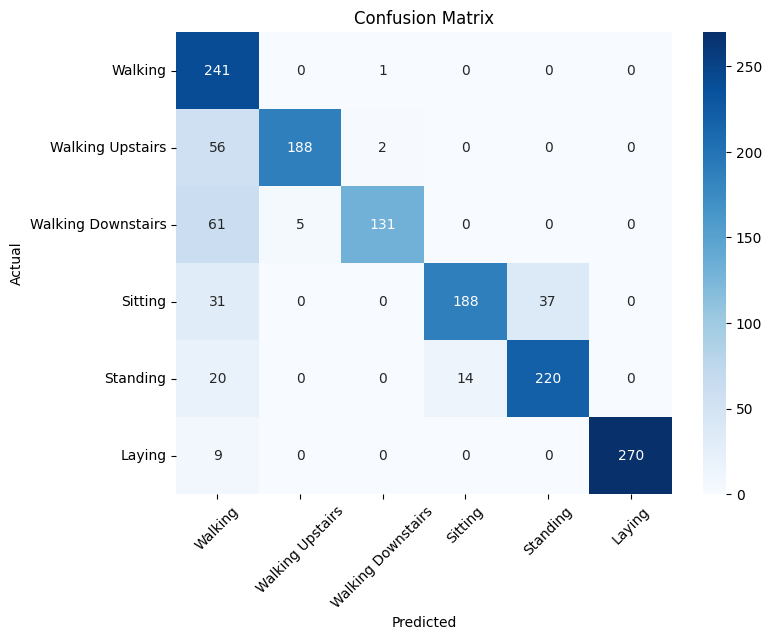

In [ ]:
# Convert labels to one-hot encoding for classification problem
y_train_categorical = to_categorical(y_train - 1, num_classes=6)  # y_train has values 1 to 6
y_val_categorical = to_categorical(y_val - 1, num_classes=6)
y_test_categorical = to_categorical(y_test - 1)

# Fit the Random Forest model
rf_model = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rf_model.fit(X_train_pca, y_train_categorical)

# Make predictions and then convert predictions into classes
y_pred_rf = rf_model.predict(X_test_pca)
y_pred_rf_classes = np.argmax(y_pred_rf, axis=1)  # Get class labels
y_true_rf_classes = np.argmax(y_test_categorical, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_categorical, y_pred_rf) 
print(f"Accuracy: {accuracy:.2f}")

# Calculate precision
precision = precision_score(y_test_categorical, y_pred_rf, average='weighted')
print(f"Precision: {precision:.2f}")

# Calculate recall
recall = recall_score(y_test_categorical, y_pred_rf, average='weighted')
print(f"Recall: {recall:.2f}")

# Calculate F1 score
f1 = f1_score(y_test_categorical, y_pred_rf, average='weighted')
print(f"F1 Score: {f1:.2f}")

# Print the classification report
print("Classification Report:")
print(classification_report(y_test_categorical, y_pred_rf))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_rf_classes, y_pred_rf_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

## Evaluate Random Forrest model for over fitting

In [12]:
# Print training and test accuracy to monitor overfitting
train_accuracy = accuracy_score(y_train_categorical, rf_model.predict(X_train_pca))
test_accuracy = accuracy_score(y_test_categorical, rf_model.predict(X_test_pca))

print(f'Training Accuracy: {train_accuracy:.2f}')
print(f'Test Accuracy: {test_accuracy:.2f}')

# Perform cross-validation to confirm results
cv_scores = cross_val_score(rf_model, X_train_pca, y_train_categorical, cv=10)
print(f'Mean Cross-Validation Score: {cv_scores.mean():.2f}')

Training Accuracy: 1.00
Test Accuracy: 0.83
Mean Cross-Validation Score: 0.79


## Build, Train and Evaluate Neural Network

Epoch 1/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.3727 - loss: 1.5819 - val_accuracy: 0.7970 - val_loss: 0.7150
Epoch 2/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8814 - loss: 0.5442 - val_accuracy: 0.9226 - val_loss: 0.3353
Epoch 3/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9392 - loss: 0.2557 - val_accuracy: 0.9355 - val_loss: 0.2321
Epoch 4/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9530 - loss: 0.1662 - val_accuracy: 0.9450 - val_loss: 0.1906
Epoch 5/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9614 - loss: 0.1302 - val_accuracy: 0.9430 - val_loss: 0.1808
Epoch 6/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9652 - loss: 0.1131 - val_accuracy: 0.9443 - val_loss: 0.1636
Epoch 7/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9664 - loss: 0.0978 - val_accuracy: 0.9450 - val_loss: 0.1558
Epoch 8/20
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9722 - loss: 0.0843 - val_accuracy: 0.

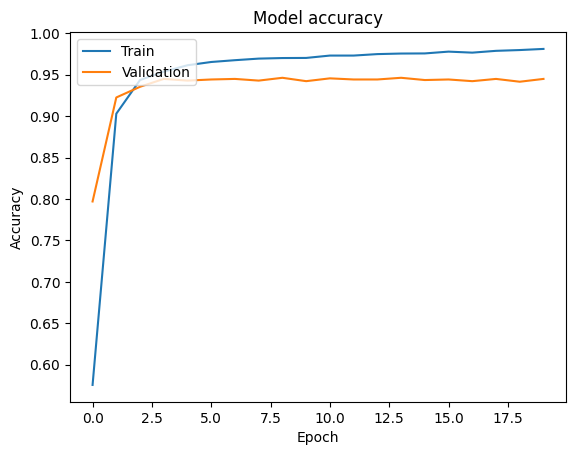

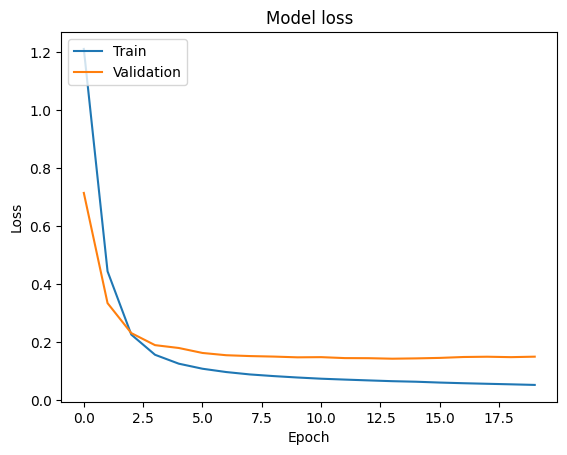

In [13]:
# Define the input shape (67 principal components)
input_shape = (67,)

# Create a Sequential model
model = Sequential()

# Add layers to the model, increasing complexity leads to overfitting very quickly
model.add(Input(shape=input_shape))  # This sets the input shape
model.add(Dense(16, activation='relu'))   # One hidden layer
model.add(Dense(6, activation='softmax'))  # Output layer

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using one-hot encoded labels
history = model.fit(X_train_pca, y_train_categorical, validation_data=(X_val_pca, y_val_categorical), epochs=20, batch_size=32)

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9427 - loss: 0.1677
Test Loss: 0.1834
Test Accuracy: 0.9396
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


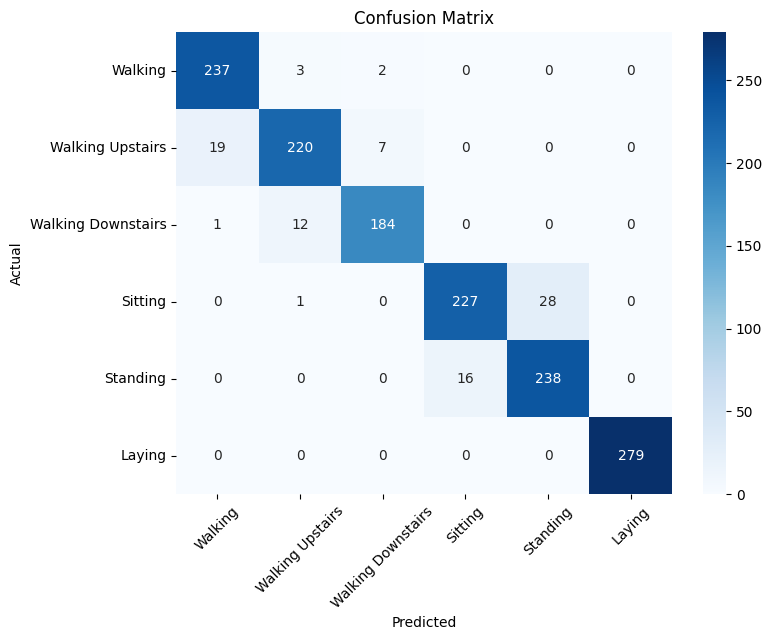

Precision: 0.9401
Recall: 0.9396
F1 Score: 0.9394
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       242
           1       0.93      0.89      0.91       246
           2       0.95      0.93      0.94       197
           3       0.93      0.89      0.91       256
           4       0.89      0.94      0.92       254
           5       1.00      1.00      1.00       279

    accuracy                           0.94      1474
   macro avg       0.94      0.94      0.94      1474
weighted avg       0.94      0.94      0.94      1474



In [14]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_pca, y_test_categorical)
print(f'Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}')

# Get predictions
y_pred = model.predict(X_test_pca)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Change to 'macro' or 'micro' as needed
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(classification_report(y_true_classes, y_pred_classes))

### ADD CROSS VALIDATION? COULD DO IT AFTER OPTIMIZING

## Build, Train and Evaluate 3rd Model